# Problem Statement
Using K-nearest neighbours based Machine learning model to classify whether a patient is suffering from diabeties or not. 

Kaggle Dataset link: [Link](https://www.kaggle.com/uciml/pima-indians-diabetes-database)

In [53]:
#importing neccessary modules
import pandas as pd
import sklearn
import os
import numpy as np
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import pickle
import json

In [19]:
|os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/DiabetiesDataset/')

In [20]:
dataset = pd.read_csv('diabetes.csv')

In [21]:
dataset.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# Observation
We can observe that there are a lot of zero values in the columns like  Blood pressure, Skin Thickness, Insulin and BMI' which we can usually consider to be of non-zero values in each patient.

Let's apply data imputation. We can replace the missing values using Mean/Median of the data, with end of tail method or simply remove the missing values using dropna.

Since mean or median imputation often distorts the original distribution od the dataset which in turn may affect the accuracy of the model. We will not use it over here.

However, since most of the observations(~99%) of a normally distributed data lie within mean ± 3 *standard deviations. so, at-times it is better to use end of tail imputatation.

Let's have a look at the distribution of the data before finalising the data imputation.



Skewness  Pregnancies                 0.901674
Glucose                     0.173754
BloodPressure              -1.843608
SkinThickness               0.109372
Insulin                     2.272251
BMI                        -0.428982
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64
******************************
Kurtosis Pregnancies                 0.159220
Glucose                     0.640780
BloodPressure               5.180157
SkinThickness              -0.520072
Insulin                     7.214260
BMI                         3.290443
DiabetesPedigreeFunction    5.594954
Age                         0.643159
Outcome                    -1.600930
dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


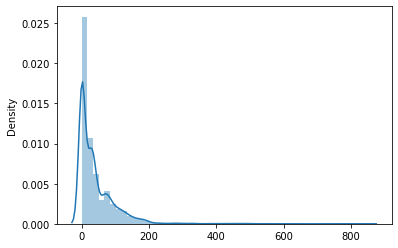

In [23]:
#checking the distribution 
print("Skewness ", dataset.skew())
print("******************************")
print("Kurtosis", dataset.kurt())
sns.distplot(dataset)

# Observation
Overall the distribution is end-tailed towards right.
We can clearly see that attributes like Blood Pressure, Insulin, BMI and DiabetiesPedigreeFunction contribute much to the overall kurtosis of the dataset.


In [28]:
end_tail_columns = ['BloodPressure','Insulin','BMI']
non_end_tail_columns = ['SkinThickness','Glucose']
columns = end_tail_columns+ non_end_tail_columns
#end tail imputation function
def end_tail_imputation(df, column):
  extreme_val = df[column].mean() + 3* df[column].std()
  return extreme_val

#iterating and replacing with the mean of non-zero values for non_end_tail columns and end_tailed values for the ones skewed.
for column in columns:
  dataset[column] = dataset[column].replace(0, np.NaN)
  if column in end_tail_columns:
    imputed_value = end_tail_imputation(dataset, column)
  elif column in non_end_tail_columns:
    imputed_value = np.ceil(dataset[column].mean(skipna=True))
  dataset[column] = dataset[column].replace(np.NaN,imputed_value)


In [29]:
dataset.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.000000,35.0,511.875789,33.600000,0.627,50,1
1,1,85.0,66.000000,29.0,511.875789,26.600000,0.351,31,0
2,8,183.0,64.000000,30.0,511.875789,23.300000,0.672,32,1
3,1,89.0,66.000000,23.0,94.000000,28.100000,0.167,21,0
4,0,137.0,40.000000,35.0,168.000000,43.100000,2.288,33,1
5,5,116.0,74.000000,30.0,511.875789,25.600000,0.201,30,0
6,3,78.0,50.000000,32.0,88.000000,31.000000,0.248,26,1
7,10,115.0,109.551659,30.0,511.875789,35.300000,0.134,29,0
8,2,197.0,70.000000,45.0,543.000000,30.500000,0.158,53,1
9,8,125.0,96.000000,30.0,511.875789,53.232429,0.232,54,1


In [32]:
# getting the feature and target columns
input_feature = dataset.iloc[:,0:8]
target_feature = dataset.iloc[:,8]
#splitting the dataset into train_test split
X_train,X_test, y_train,y_test = train_test_split(input_feature, target_feature, random_state=42, test_size=0.3)

In [33]:
#printing the shapes 

print("Shape of Train Input features", X_train.shape)
print("Shape of Train Target feature", y_train.shape)
print("Shape of Test Input features", X_test.shape)
print("Shape of Test Target feature",y_test.shape)

Shape of Train Input features (537, 8)
Shape of Train Target feature (537,)
Shape of Test Input features (231, 8)
Shape of Test Target feature (231,)


In [34]:
#feature scaling
FT = StandardScaler()
FT.fit(X_train)
X_train = FT.transform(X_train)
X_test = FT.transform(X_test)

In [39]:
#fetching the params
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [49]:
#hyperparameter tuning on few of the aforementioned keys
grid_params = {
    'n_neighbors' : list(np.linspace(1,20,20,dtype=int)),
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params,verbose=1, cv=3, n_jobs=8).fit(X_train, y_train).best_estimator_


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed:    1.4s finished


In [50]:
#predicting
print(model.predict([X_test[0,:]]))

[0]


In [51]:
#printing the score
model.score(X_test,y_test)

0.7272727272727273

In [54]:
y_pred = model.predict(X_test)

In [55]:
#printing the confusion matrix
confusion_matrix(y_test, y_pred)


array([[124,  27],
       [ 36,  44]])

In [56]:
f1_score(y_test,y_pred)

0.5827814569536425

In [57]:
accuracy_score(y_test, y_pred)

0.7272727272727273

# Observation
Here f1 score is a more valuable metric than accuracy score since we are also concerned about FP besides TP, FN as it may confuse the doctor to treat a patient who doesn't suffer from diabeties.

In [58]:
#saving the model for serving
with open('diabeties_classification_model.pkl','wb') as f:
    pickle.dump(model,f)
